In [21]:
import requests
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date, timedelta


ticker = 'AAPL'
current = yf.Ticker(ticker)

current_year = date.today().year

#quarterly data
cashflow = current.quarterly_cashflow
financials = current.quarterly_financials
balance_sheet = current.quarterly_balance_sheet

#annual data
years_index = current.shares.index.to_list() # list of years to use as keys
years_index.append(current_year)
annual_earnings = current.earnings["Earnings"].to_dict() # earnings dict with years as keys
shares = current.shares['BasicShares'].to_dict() # shares dict with years as keys

fivey_hist = current.history(period="5y")

In [24]:
#method to get quarterly filing dates. Returns list of dates
file_dates = [(date.today()- timedelta(days = 1)).strftime('%Y-%m-%d')]
for date in balance_sheet.columns.to_list():
    while date.strftime('%Y-%m-%d') not in fivey_hist["Close"].keys():
        date = date - pd.Timedelta(days=1)
    file_dates.insert(0, date.strftime('%Y-%m-%d'))

#list of close prices at quarterly filing date
quarterly_close_price = [fivey_hist["Close"].loc[date] for date in file_dates]

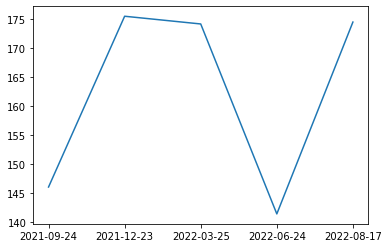

In [25]:
plt.plot(file_dates, quarterly_close_price)

In [6]:
def plotter(data, title, x_axis = None, y_axis = None, ):
    
    return 

Text(0.5, 1.0, 'Annual EPS')

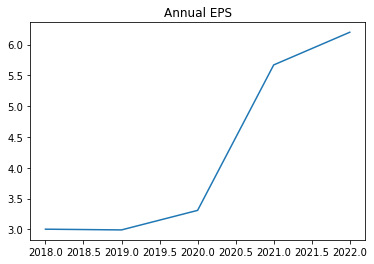

In [7]:
# estimating [current_year] annual data using quarterly data
estimated_earnings = current.quarterly_earnings['Earnings'].sum()
current_shares = current.info['sharesOutstanding']


annual_earnings[current_year] = estimated_earnings
shares[current_year] = current_shares

# EPS per year dictionary
annual_EPS = {}
for year in years_index:
    eps = annual_earnings.get(year)/shares.get(year)
    annual_EPS[year] = eps

plt.plot(years_index, annual_EPS.values())
plt.title('Annual EPS')

In [8]:
# Splitting 5yr hist into respective years
years_index_timestamp = [pd.Timestamp(year = y, month = 1, day = 1) for y in years_index]

yearly_hist = {}
for i in range(len(years_index_timestamp) - 1):
    start = years_index_timestamp[i]
    cutoff = years_index_timestamp[i+1]
    
    close = current.history(start = start, end=cutoff)
    yearly_hist[years_index[i]] = close
yearly_hist[years_index[-1]] = current.history(start = years_index_timestamp[-1], end=None)



In [9]:
# Getting daily PE ratios for each year based on annual_EPS and yearly_hist
yearly_PE = {}
for year in years_index:
    close = yearly_hist[year]['Close'].to_list()
    PE_ratio = [price/annual_EPS[year] for price in close]
    yearly_PE[year] = PE_ratio

Text(0.5, 1.0, '2018 PE')

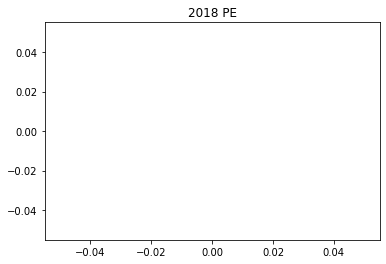

In [10]:
plt.plot()
plt.title('2018 PE')
